# Bayesian model

## Assignment A
ML for isothermal/non-isothermal H2-Ni interactions -> there is no rotational velocity

In [1]:
import sys
print(sys.executable)


c:\Users\jespe\miniconda3\python.exe


In [4]:
import os
import numpy as np
from scipy.special import erf, erfinv
#from math import erf
from numpy.linalg import norm
from mlmm import VelocityData, plot_learn_curve, n_fold_cv, fileinfo,VelocityDataOmegaData, OmegaData

import matplotlib.pyplot as plt

from datetime import date
today = date.today().strftime("%b-%d-%Y")
import periodictable

import sys
from mlmm import func_postprocess
import time



er_type = 'MAE'

system_6D = True # Assignment A uses 6D data since we are using only the translational velocity data
system_10D = False
system_omega = False # Set to false, since we are not using angular velocity data in this assignment
wall_temp = 300
Liao_Transfer_Function = True

kB,conv_v,conv_omega,av_num = 1.38064852e-23,1.0e2,1.0e12,6.022e23




x_data = [
          ]
y_data = [
          ]

x_omega = []
y_omega = []

x_MD = []
y_MD = []

# Path to the data files for Task 1
# Materials_for_ML_assignment\H2_IsoThermalWalls_Sw_0\H2_Vel_MD_Sw_0_B300_Th_300.txt  
# Materials_for_ML_assignment\H2_NonIsoThermalWalls_Sw_0\H2_Vel_MD_Sw_0_T500_Tb_300.txt  
# Materials_for_ML_assignment\H2_NonIsoThermalWalls_Sw_0\H2_Vel_MD_Sw_0_B300_Th_500.txt

path_to_data = 'Data_H2_assignment_bayesian_A'
path_save_data='./'+path_to_data
#path_to_data = 'Shahin/test_data/'



for file in os.listdir(path_to_data):

    if file.endswith(".txt") and "MD" in file:
        x_MD.append(os.path.join(path_to_data,file))
        y_MD.append('')

    if file.endswith(".txt") and "omega" in file:
        x_omega.append(os.path.join(path_to_data,file))
        y_omega.append('')
print("Data files found:",x_MD)


######################################################################################
#------------------------------- Getting translational velocity data
####--------------------------------------------------------------------------------------------------
for x_data_file,y_data_file in zip(x_MD,y_MD):
    

    conf = VelocityData(x_data_file, frames=None)#[0,30000])
    conf.getRep(rep='vxvyvz',nuc=None) #rep options: vxvyvz, vel2norm, vx2,vy2,vz2,vx,vy,vz
    file_name=x_data_file.replace('.','/')
    file_name=file_name.split('/')
    set_name = file_name[1]
    X = conf.X
    y = conf.y
    if "He" in path_to_data:
        mass = getattr(periodictable,'He').mass
        gas_name = 'He'
    elif "Ar" in path_to_data:
        mass = getattr(periodictable,'Ar').mass
        gas_name = 'Ar'
    elif "H2" in path_to_data:
        mass =2* getattr(periodictable,'H').mass
        gas_name = 'H2'
        l_b=0.741e-10
        mass_kg = mass * 0.001 / av_num
        I=(mass_kg/4)*l_b**2
    elif "N2" in path_to_data:
        mass =2* getattr(periodictable,'N').mass
        gas_name = 'N2'
        l_b=1.097e-10
        mass_kg = mass * 0.001 / av_num
        I=(mass_kg/4)*l_b**2
    else:
        print ("Unable to identify impinging atom type...")
        ele = str(input("Enter the impinging atom symbol : "))
        mass = getattr(periodictable,ele).mass
        v_mp = np.sqrt(2 * kB * wall_temp / mass_kg)
        omega_mp = np.sqrt(2 * kB * wall_temp / I)
    print ('Atomic mass for {} molecule is {:1.4f} \n'.format(gas_name,mass))
    n_MD = X.shape[0]
    print('Number of MD tr velocity data points: {} \n'.format(n_MD))
    # Implementing Liao Transfer function on perpendicular velocity component
    v_TF,T_in,T_out,theta_in,theta_out=func_postprocess.liao_transform(X,mass,'y')


######################################################################################
#------------------------------- Getting angular velocity data
####--------------------------------------------------------------------------------------------------
if system_omega:
    for x_data_file2,y_data_file2 in zip(x_omega,y_omega):
        #conf2 = OmegaData(x_data_file2, frames=frames)#[0,30000])
        conf2 = OmegaData(x_data_file2, frames=None)#[0,30000])
        conf2.getRep(rep='omega1omega2',nuc=None) #rep options: vxvyvz, vel2norm, vx2,vy2,vz2,vx,vy,vz
        omega_file_name = x_data_file2.replace('.','/')
        omega_file_name = omega_file_name.split('/')
        omega_name = omega_file_name[1]
        print(omega_name)
        X2 = conf2.X2
        y2 = conf2.y2
        print('Number of MD rot velocity data points: {} \n'.format(X2.shape[0]))
        X2_TF=np.copy(X2)
        Y2_TF=np.copy(y2)
        omega_TF=np.vstack((X2_TF,-X2_TF))
        y2_TF=np.hstack((Y2_TF,-Y2_TF))   

######################################################################################
#------------------------------- Implementing GM model on 10D data
####--------------------------------------------------------------------------------------------------                   

if system_10D:
    vel_tr = np.copy(X)
    vel_tr[:,1]=np.abs(vel_tr[:,1])
    vel_tr[:,4]=np.abs(vel_tr[:,4])
    data_for_AC_MD = np.concatenate((vel_tr,X2),axis=1)

    
    if Liao_Transfer_Function:
        #omega_bond = np.copy(X2)
        v_tr=np.copy(v_TF[:n_MD,:])
        v_omega = np.copy(X2)
        v_mp = np.sqrt(2 * kB * wall_temp / mass_kg)
        omega_mp = np.sqrt(2 * kB * wall_temp / I)
        #--- Normalazing the translational and rotational velocities
        data_train_10D = np.concatenate((v_tr*conv_v/v_mp,X2*conv_omega/omega_mp),axis=1)

        print('The total number of training points is: {} \n'.format(data_train_10D.shape[0]))
        
    else:
        data_train_10D = data_for_AC_MD
        print('The total number of training points is: {} \n'.format(data_train_10D.shape[0]))

Data files found: ['Data_H2_assignment_bayesian_A\\H2_Vel_MD_Sw_0_B300_Th_300.txt']
Generating Representation


0% [#######                       ] 100% | ETA: 00:00:00

Not a float


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Atomic mass for H2 molecule is 2.0159 

Number of MD tr velocity data points: 123351 



## Preprocessing

In [21]:
# 1 Bayesian model - preprocessing
import pandas as pd

X_df = pd.DataFrame(X, columns=['vx_in', 'vy_in', 'vz_in', 'vx_out', 'vy_out', 'vz_out'], copy=True)

X_in = np.copy(X[:,:3])
X_out = np.copy(X[:,3:])

X_df = X_df[:8000] # Take small percentage of data for testing
X_df

# TODO: something is done with the y data to convert it to gaussian, and later back, because it is now Rayleigh distributed -> todo: look in paper what is being done

,vx_in,vy_in,vz_in,vx_out,vy_out,vz_out
0,-19.063490,-2.721230,-1.898435,-10.097920,14.351700,-10.128445
1,-14.207510,-12.694940,8.064925,19.730700,4.442650,-4.679550
2,10.970280,-15.174750,-7.416400,-4.919135,10.238755,10.174040
3,12.163100,-18.675745,10.151765,-18.584276,21.490740,-7.930920
4,-19.325736,-20.558550,-14.049560,-10.264800,11.402860,-10.448760
...,...,...,...,...,...,...
7995,-12.061535,-8.590515,-0.130090,-3.194685,4.450525,-11.714310
7996,-6.118010,-6.361820,-16.486515,-8.960550,8.107655,3.522915
7997,-4.635415,-17.308200,-8.417390,-2.843985,18.797300,-4.761210
7998,-15.087520,-5.410535,-4.443265,-1.922335,18.655200,12.232250


## Visualizing the data

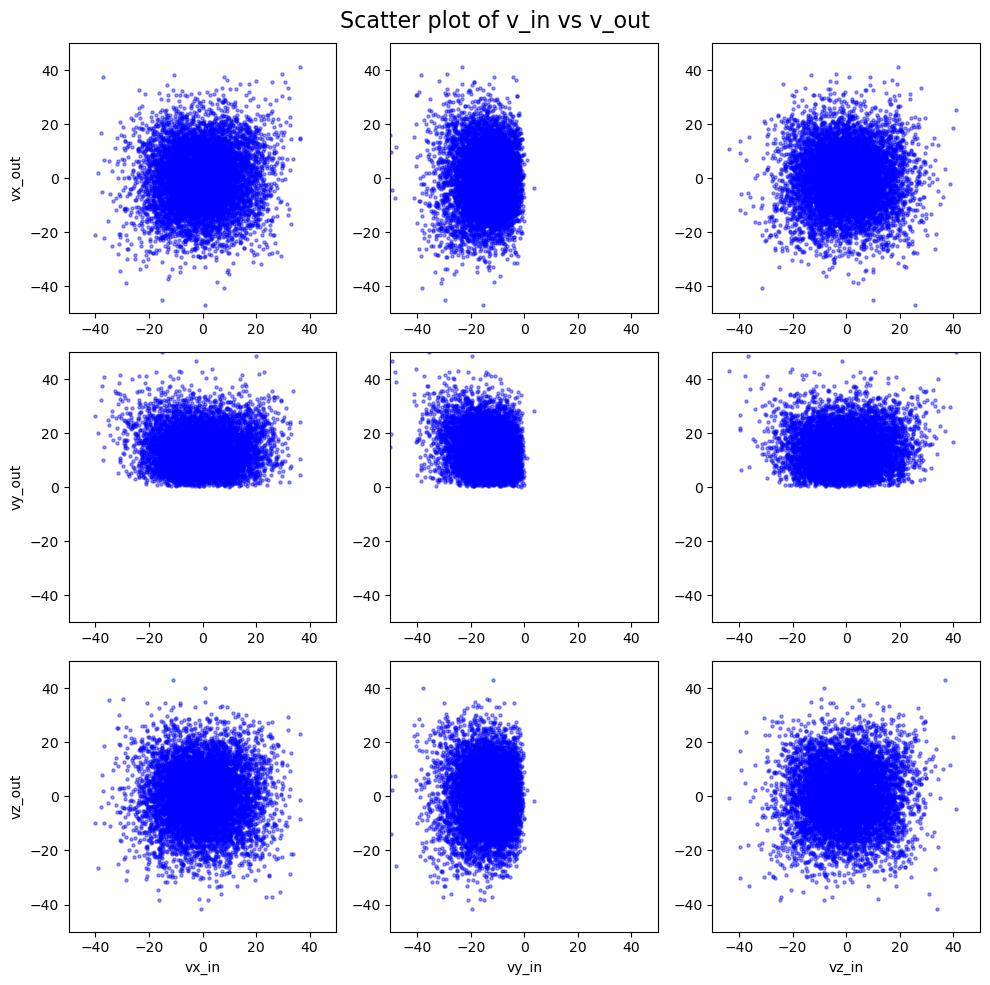

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
labels = ["x", "y", "z"]
for row in range(3):
    ax[row, 0].set_ylabel(f'v{labels[row]}_out')  
    ax[2, row].set_xlabel(f'v{labels[row]}_in')
    for column in range(3):
        v_in = X_df.iloc[:, column]  # Correctly select v_in for each column
        v_out = X_df.iloc[:, row + 3]  # Correctly select v_out for each row
        ax[row, column].scatter(v_in, v_out, c='blue', s=5, alpha=0.4, label='Data points')
        ax[row,column].set_xlim(-50,50)
        ax[row,column].set_ylim(-50,50)
fig.suptitle('Scatter plot of v_in vs v_out', fontsize=16)
fig.tight_layout()
plt.show()


In [23]:
# setup the bayesian gaussian mixture model and normal gaussian mixture model (for comparison)
# TODO: also setup CLL-model for comparison
# https://www.geeksforgeeks.org/bayesian-model-selection/
# https://scikit-learn.org/stable/modules/mixture.html#variational-bayesian-gaussian-mixture
# https://mlg.eng.cam.ac.uk/zoubin/talks/mathpsych03.pdf
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# NOTE: the following code is a work in progress. For now, just use N = 600 because it is the amount that the paper uses: from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
# Find optimal number of commponents and covariance type using BIC score
def bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

grid_search_gaussian = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=bic_score
)

grid_search_bayesian = GridSearchCV(
    BayesianGaussianMixture(), param_grid=param_grid, scoring=bic_score
)

# Fit the models
grid_search_gaussian.fit(X_df)
grid_search_bayesian.fit(X_df)


KeyboardInterrupt: 

## Train both models

In [31]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture

# N_G as from the literature. TODO: plot N_G vs accomodation coefficient, as is done in the literature
N_G = 600

# Create a function to make and fit a GMM model
def initialize_gmm(X, n_components):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(X)
    return gmm

# Create a function to make and fit a Bayesian GMM model
def initialize_bayesian_gmm(X, n_components):
    bayesian_gmm = BayesianGaussianMixture(n_components=n_components)
    bayesian_gmm.fit(X)
    return bayesian_gmm

# TODO: lookup how the accomodation coefficient is calculated in the paper and create a for loop to calculate it for all possible models (N_G =1 to 1000)


## Visualize the PDF of both models

In [32]:
gmm_model = initialize_gmm(X_df, N_G)
bayesian_model = initialize_bayesian_gmm(X_df, N_G)

c:\Users\jespe\miniconda3\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


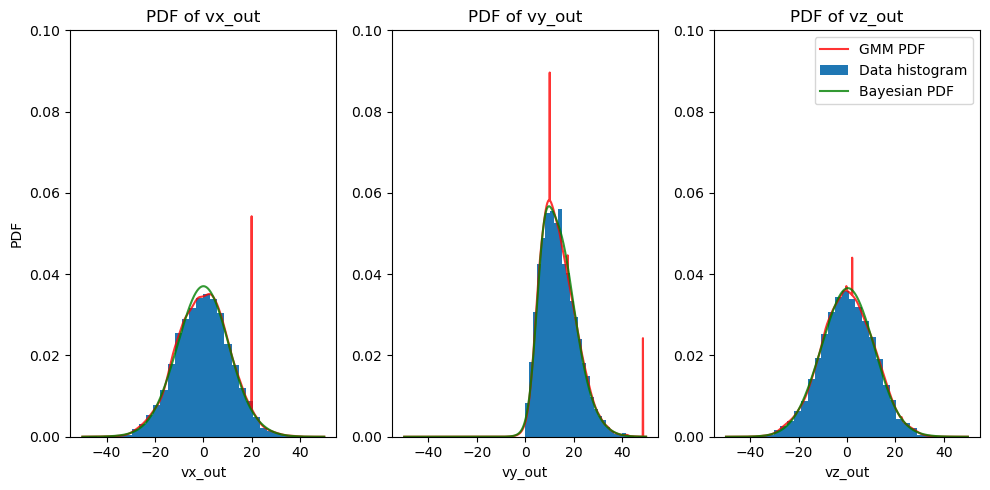

In [33]:
from numpy.linalg import norm as linalg_norm
from scipy.stats import norm


# Extract marginal pdf for each feature from the GMM model
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

labels = ["vx_out", "vy_out", "vz_out"]
feature_index = [3, 4, 5]
xlim = np.linspace(-50, 50, 1000)

for i in range(3):
    pdf_gmm = np.zeros_like(xlim)
    pdf_bayesian = np.zeros_like(xlim)

    for j in range(N_G):
        # Extract the mean, covariance, and weight for each gmm component
        mean_gmm = gmm_model.means_[j, feature_index[i]]
        cov_gmm = gmm_model.covariances_[j, feature_index[i], feature_index[i]]
        weight_gmm = gmm_model.weights_[j]
        pdf_gmm += weight_gmm * norm.pdf(xlim, loc=mean_gmm, scale=np.sqrt(cov_gmm))
        
        # Extract the mean, covariance, and weight for each bayesian component
        mean_bayesian = bayesian_model.means_[j, feature_index[i]]
        cov_bayesian = bayesian_model.covariances_[j, feature_index[i], feature_index[i]]
        weight_bayesian = bayesian_model.weights_[j]
        pdf_bayesian += weight_bayesian * norm.pdf(xlim, loc=mean_bayesian, scale=np.sqrt(cov_bayesian))

        # Compute histogram
        

    # Visualize the pdf of the gmm as a line plot
    ax[i].plot(xlim, pdf_gmm, c='red', alpha=0.8, label='GMM PDF')
    ax[i].hist(X_df.iloc[:,feature_index[i]], bins=30, density=True, label='Data histogram')
    
    # Visualize the pdf of the bayesian model as a line plot
    ax[i].plot(xlim, pdf_bayesian, c='green', alpha=0.8, label='Bayesian PDF')
    ax[i].set_ylim([0, 0.10])
    ax[i].set_xlabel(f'{labels[i]}')
    ax[i].set_title(f'PDF of {labels[i]}')
    
    
ax[0].set_ylabel("PDF")
ax[2].legend(loc=1)
fig.tight_layout()
plt.show()
